In [1]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from dask.distributed import Client
import pprint 
# functions.ipynb contains functions to calculate ozone in dobzon units from mol/mol and the weight calculator
%run /home/jovyan/escience-2022/Tjaernoe2022-group2/notebooks/functions.ipynb
%matplotlib inline

NotJSONError: Notebook does not appear to be JSON: '{\n "cells": [\n  {\n   "cell_type": "c...

In [54]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42643")
client

<Client: 'tcp://127.0.0.1:42643' processes=5 threads=20, memory=78.51 GiB>

In [ ]:
client.close()

# Open CMIP6 online catalog & download desired data

In [9]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
waccm = col.search(source_id=['CESM2-WACCM'], experiment_id=['historical'], table_id=['Amon'], variable_id=['o3'])
cam = col.search(source_id=['CESM2'], experiment_id=['historical'], table_id=['Amon'], variable_id=['o3'], member_id=['r1i1p1f1','r2i1p1f1','r3i1p1f1'])
print(waccm.df)
print(cam.df)

In [37]:
ds_dict_waccm = waccm.to_dataset_dict(zarr_kwargs={'use_cftime':True}, cdf_kwargs={"chunks": {"time": 40}})
ds_dict_cam = cam.to_dataset_dict(zarr_kwargs={'use_cftime':True},cdf_kwargs={"chunks": {"time": 4}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [38]:
print(list(ds_dict_waccm.keys()))
print(list(ds_dict_cam.keys()))
ds_waccm = ds_dict_waccm['CMIP.NCAR.CESM2-WACCM.historical.Amon.gn']
ds_cam = ds_dict_cam['CMIP.NCAR.CESM2.historical.Amon.gn']

['CMIP.NCAR.CESM2-WACCM.historical.Amon.gn']
['CMIP.NCAR.CESM2.historical.Amon.gn']


# Rechunk the dataset to optimize dask

In [99]:
# Each worker should have en even number of workload. 
# For this dataset I have time:1980 divided by 5 gives me an even number of 396.
# I should therefore have 5 workers when using dask.
# This will also wotk if I decide to calculate the yearly mean. 
# I have 165 years. 5 workers will then each have 33 years to work on simultaneously 

# This dataset is already chunked as wished, no need to change
ds_waccm.o3[0]

,Array,Chunk
Bytes,7.75 GiB,240.47 MiB
Shape,"(1980, 19, 192, 288)","(60, 19, 192, 288)"
Count,11 Graph Layers,33 Chunks
Type,float32,numpy.ndarray


# Select time period 
# This is for Mount Pinatubo eruption

In [72]:
start = cftime.DatetimeNoLeap(1985,1,15)
end = cftime.DatetimeNoLeap(1996,1,15)

# WACCM
ds_waccm_1986_1996 = ds_waccm.sel(time=slice(start, end))
# CAM
ds_cam_1986_1996 = ds_cam.sel(time=slice(start, end))

## Calculate ozone from concentration to Dobson units

In [73]:
# Creates a new variable called totO3 for WACCM and CAM 
ds_waccm_1986_1996 = calculate_total_ozone_p(ds_waccm_1986_1996)
ds_cam_1986_1996 = calculate_total_ozone_p(ds_cam_1986_1996)

Minimum column ozone value: 58.61533162268342


## Calculate the anomaly

In [75]:
# Select 5 years post volcanic eruption to see the effect on the ozone
end_prior_eruption = cftime.DatetimeNoLeap(1991,1,15)

# WACCM
ds_waccm_post_eruption = ds_waccm_1986_1996['totO3'].squeeze().groupby('time.year').mean('time', keep_attrs=True)
ds_waccm_climatology = ds_waccm_1986_1996['totO3'].sel(time=slice(start,end_prior_eruption)).squeeze().groupby('time.year').mean('time', keep_attrs=True).mean('year', keep_attrs=True)
ds_waccm_anomaly = ds_waccm_post_eruption - ds_waccm_climatology
ds_waccm_anomaly.attrs = ds_waccm_climatology.attrs

# CAM
ds_cam_post_eruption = ds_cam_1986_1996['totO3'].squeeze().groupby('time.year').mean('time', keep_attrs=True)
ds_cam_climatology = ds_cam_1986_1996['totO3'].sel(time=slice(start,end_prior_eruption)).squeeze().groupby('time.year').mean('time', keep_attrs=True).mean('year', keep_attrs=True)
ds_cam_anomaly = ds_cam_post_eruption - ds_cam_climatology
ds_cam_anomaly.attrs = ds_cam_climatology.attrs

## Calculate the weights

In [80]:
# Calculate the weight for the northern and southern hemispheres
# WACCM
waccm_weight_north_anomaly = computeWeightedMean(ds_waccm_anomaly.where(ds_waccm_anomaly['lat']>60.)).compute()
waccm_weight_south_anomaly = computeWeightedMean(ds_waccm_anomaly.where(ds_waccm_anomaly['lat']<-60.)).compute()

# CAM
cam_weight_north_anomaly = computeWeightedMean(ds_cam_anomaly.where(ds_cam_anomaly['lat']>60.)).compute()
cam_weight_south_anomaly = computeWeightedMean(ds_cam_anomaly.where(ds_cam_anomaly['lat']<-60.)).compute()

In [94]:
# Attributes are lost in the computeWeightedMean? why?
waccm_weight_north_anomaly.attrs = ds_cam_climatology.attrs
waccm_weight_south_anomaly.attrs = ds_cam_climatology.attrs
cam_weight_north_anomaly.attrs = ds_cam_climatology.attrs
cam_weight_south_anomaly.attrs = ds_cam_climatology.attrs

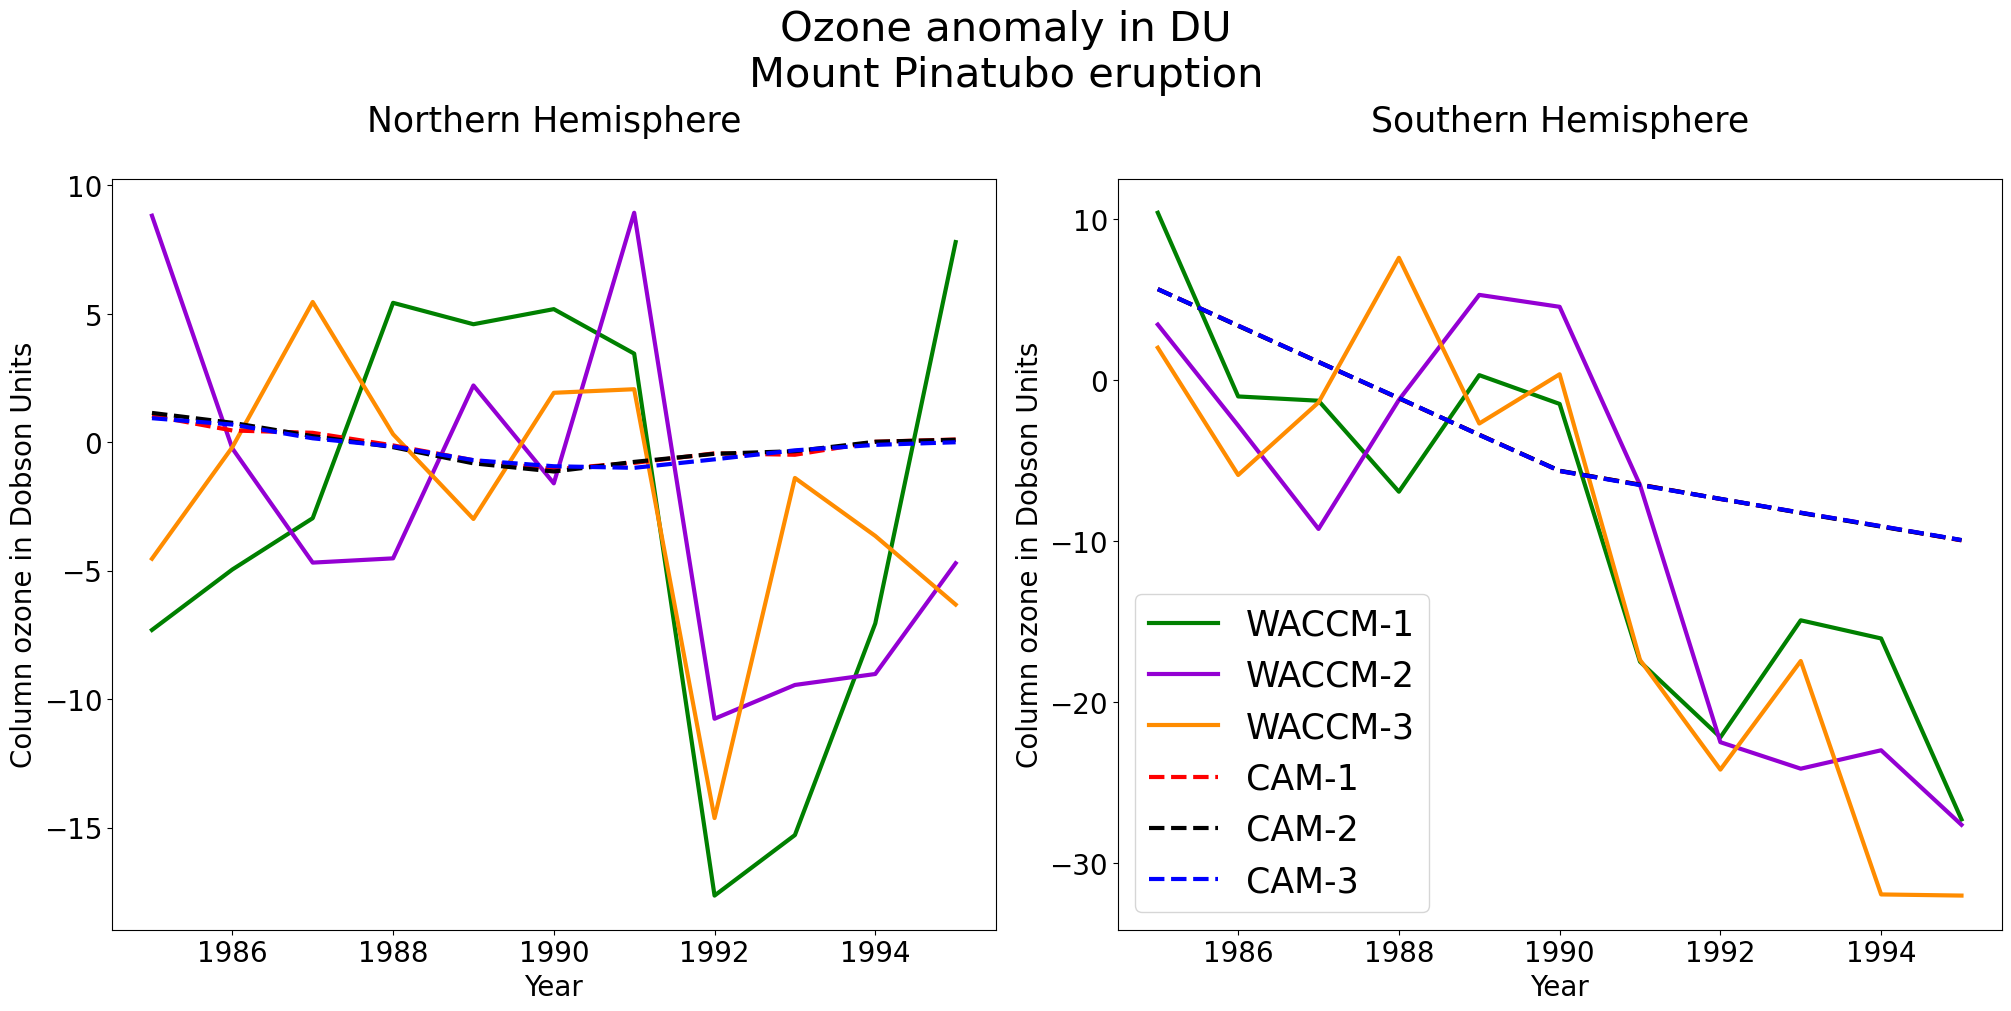

In [127]:
fig, (axs1, axs2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20,10))
color_cam = ['red','black','blue']
color_waccm = ['green','darkviolet','darkorange']

for i in range(3):
    j = i+1
    waccm_weight_north_anomaly[i].plot(label="WACCM-"+ str(j), ax=axs1, linewidth=3, color=color_waccm[i])
    waccm_weight_south_anomaly[i].plot(label='WACCM-'+ str(j), ax=axs2, linewidth=3, color=color_waccm[i])

for i in range(3):
    j = i+1
    cam_weight_north_anomaly[i].plot(label="CAM-"+ str(j), ax=axs1, linestyle='--', linewidth=3, color=color_cam[i])
    cam_weight_south_anomaly[i].plot(label="CAM-"+ str(j), ax=axs2, linestyle='--', linewidth=3, color=color_cam[i])

fig.suptitle('Ozone anomaly in DU\nMount Pinatubo eruption', fontsize=30)


axs1.set_ylabel(waccm_weight_south_anomaly[0].long_name, fontsize=20)
axs2.set_ylabel(cam_weight_south_anomaly[0].long_name, fontsize=20)

axs1.set_xlabel('Year', fontsize=20)
axs2.set_xlabel('Year', fontsize=20)

axs1.tick_params(axis="x", labelsize=20)
axs2.tick_params(axis="x", labelsize=20)

axs1.tick_params(axis="y", labelsize=20)
axs2.tick_params(axis="y", labelsize=20)

axs1.set_title(" Northern Hemisphere \n" , fontsize=25)
axs2.set_title(" Southern Hemisphere \n" , fontsize=25)

plt.legend(fontsize=25)

# Select time period

# This is for Sarychev Peak eruption

In [ ]:
start_sary = cftime.DatetimeNoLeap(2005,1,15)
end_sary = cftime.DatetimeNoLeap(2015,1,15)

# WACCM
ds_waccm_2005_2015 = ds_waccm.sel(time=slice(start_sary, end_sary))
# CAM
ds_cam_2005_2015 = ds_cam.sel(time=slice(start_sary, end_sary))

# Creates a new variable called totO3 for WACCM and CAM 
ds_waccm_2005_2015 = calculate_total_ozone_p(ds_waccm_2005_2015)
ds_cam_2005_2015 = calculate_total_ozone_p(ds_cam_2005_2015)

In [1]:
ds_waccm_2005_2015_sary.groupby('time.year').mean('time')

NameError: name 'ds_waccm_2005_2015_sary' is not defined

In [ ]:
# Select 5 years post volcanic eruption to see the effect on the ozone
end_prior_eruption_sary = cftime.DatetimeNoLeap(2009,1,15)

# WACCM
ds_waccm_post_eruption_sary = ds_waccm_2005_2015['totO3'].squeeze().groupby('time.year').mean('time', keep_attrs=True)
ds_waccm_climatology_sary = ds_waccm_2005_2015_sary['totO3'].sel(time=slice(start_sary,end_prior_eruption_sary)).squeeze().groupby('time.year').mean('time', keep_attrs=True).mean('year', keep_attrs=True)
ds_waccm_anomaly_sary = ds_waccm_post_eruption_sary - ds_waccm_climatology_sary
ds_waccm_anomaly_sary.attrs = ds_waccm_climatology_sary.attrs

# CAM
ds_cam_post_eruption_sary = ds_waccm_2005_2015['totO3'].squeeze().groupby('time.year').mean('time', keep_attrs=True)
ds_cam_climatology_sary = ds_cam_2005_2015['totO3'].sel(time=slice(start_sary,end_prior_eruption_sary)).squeeze().groupby('time.year').mean('time', keep_attrs=True).mean('year', keep_attrs=True)
ds_cam_anomaly_sary = ds_cam_post_eruption_sary - ds_cam_climatology_sary
ds_cam_anomaly_sary.attrs = ds_cam_climatology_sary.attrs